# Normalizing and Tokenizing the Data

In [1]:
# Jupyter magic methods
# For auto-reloading when external modules are changed
%load_ext autoreload
%autoreload 2
# For showing plots inline
%matplotlib inline

# numpy: linear algebra.
import numpy as np

# pandas: tabular data.
import pandas as pd
pd.set_option('float_format', '{:f}'.format)

# pytorch: ML.
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# matplotlib and seaborn: plotting
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

In [2]:
# Give the notebook access to the rest of your google drive files.
from google.colab import drive
drive.mount("/content/drive", force_remount=True)
# Enter the relevant foldername
FOLDERNAME = '/content/drive/My Drive/ML/arxiv_vixra/'
assert FOLDERNAME is not None, "[!] Enter the foldername."
# For importing .py modules stored in FOLDERNAME or a subdirectory:
import sys
sys.path.append(FOLDERNAME)

Mounted at /content/drive


# Importing Data

Only use the training set.

In [3]:
balanced_train_file = 'balanced_filtered_data_train.feather'
large_train_file = 'large_filtered_data_train.feather'
SUBDIR = 'data/data_splits/'
balanced_path = FOLDERNAME + SUBDIR + balanced_train_file
large_file = FOLDERNAME + SUBDIR + large_train_file

!cp '{large_file}' .
!cp '{balanced_path}' .
!ls

balanced_filtered_data_train.feather  large_filtered_data_train.feather
drive				      sample_data


In [4]:
balanced_train_df = pd.read_feather(balanced_train_file, columns=['title', 'abstract', 'source'])
balanced_train_df.head()

,title,abstract,source
0,Emergence of Spatio-Temporal Certainty (1+2+3)...,"The well - known philosophical formula: ""Space...",vixra
1,New Operations on Intuitionistic Fuzzy Soft Se...,"In this paper , we have defined First Zadeh’s ...",vixra
2,What to not do in Pediatrics a Periodically Up...,This paper proposes an important RED list of w...,vixra
3,Quantum of Canonical Electromagnetic Angular M...,\begin{abstract}\r\n It is analytically dete...,vixra
4,Superconducting and Diamond Qubits,Important challenges in creating practical qua...,vixra


In [5]:
large_train_df = pd.read_feather(large_train_file, columns=['title', 'abstract', 'source'])
large_train_df.head()

,title,abstract,source
0,Calculation of prompt diphoton production cros...,A fully differential calculation in perturba...,arxiv
1,Sparsity-certifying Graph Decompositions,"We describe a new algorithm, the $(k,\ell)$-...",arxiv
2,The evolution of the Earth-Moon system based o...,The evolution of Earth-Moon system is descri...,arxiv
3,A determinant of Stirling cycle numbers counts...,We show that a determinant of Stirling cycle...,arxiv
4,From dyadic $\Lambda_{\alpha}$ to $\Lambda_{\a...,In this paper we show how to compute the $\L...,arxiv


# Importance of Normalizing

Let's build up the sets of characters for arxiv and vixra papers for each dataset. Just look at the balanced dataset for now.

In [6]:
balanced_train_df_dic = {key: balanced_train_df[balanced_train_df['source'] == key] for key in {'arxiv', 'vixra'}}

We perform some mild normalization at this stage by using `lower` on the text. In particular, we don't `strip`.

In [7]:
def mild_normalizer(s):
    return s.lower()

In [8]:
balanced_train_char_mild_norm_dic = {}
for key, df in balanced_train_df_dic.items():
    for text_col in ('title', 'abstract'):
        temp_char_set = set(' ') # Start with a space in the set.
        for text in df[text_col]:
            for char in text:
                new_char = mild_normalizer(char)
                temp_char_set.add(new_char)
        balanced_train_char_mild_norm_dic[f'{key}_{text_col}_chars'] = temp_char_set   

Check out the number of unique characters in each slice of the dataset:

In [9]:
[(key, len(val)) for key, val in balanced_train_char_mild_norm_dic.items()]

[('arxiv_title_chars', 71),
 ('arxiv_abstract_chars', 71),
 ('vixra_title_chars', 172),
 ('vixra_abstract_chars', 393)]

In [10]:
balanced_train_char_mild_norm_differences_dic = {}
for key1, key2 in (('vixra_title_chars', 'arxiv_title_chars'),
             ('arxiv_title_chars', 'vixra_title_chars'),
             ('vixra_abstract_chars', 'arxiv_abstract_chars'),
             ('arxiv_abstract_chars', 'vixra_abstract_chars')
             ):
    balanced_train_char_mild_norm_differences_dic[f"{key1.replace('_chars', '')}_only"] = [char for char in balanced_train_char_mild_norm_dic[key1] - balanced_train_char_mild_norm_dic[key2]]

In [11]:
for key, item in balanced_train_char_mild_norm_differences_dic.items():
    print(key, item)

vixra_title_only ['≡', '∫', '÷', 'ñ', '®', '∗', '\xa0', 'ó', 'µ', '\xad', 'ä', '《', '¨', '¸', 'π', '‒', 'ξ', '…', '─', 'β', 'ı', 'τ', '→', 'ï', 'ε', 'ζ', 'ö', 'ğ', '’', 'ś', '¯', 'è', '‑', '≥', 'ú', 'ﬀ', '≤', 'à', '×', 'ã', '−', 'ô', 'æ', '¡', 'о', '�', '²', '—', 'α', 'γ', '̶', 'ⅰ', '‐', '．', '：', '\u200b', '√', '“', 'á', 'ν', 'ﬁ', 'é', 'ψ', 'ℇ', 'ș', 'ӧ', '\u200e', '–', 'ü', 'μ', 'ç', 'т', '》', '∈', '）', '‘', 'ă', 'λ', '«', 'ê', '∙', 'ş', 'σ', '\uf061', 'ù', 'φ', 'â', 'í', 'ﬂ', '′', '´', '―', '\u3000', '§', 'δ', '”', 'ő', 'ϕ', '¶', '»', 'ω', 'ⅲ', '±']
arxiv_title_only ['\x7f', '\n']
vixra_abstract_only ['≡', 'ℜ', 'а', '∫', 'ž', 'з', '\u2005', '®', 'ʻ', '∗', '\xa0', '∆', '⁻', '⊗', '】', '\uf0bb', '⊝', '△', '（', 'κ', 'ó', 'µ', 'ī', 'ɸ', '\xad', '\uf070', 'ä', 'н', 'с', '\uf0b7', '¬', '¨', 'º', '∃', 'π', '‒', 'š', '…', '！', '─', 'î', '\uf020', 'ı', ';', '▒', 'ē', 'õ', 'ℕ', '̄', '●', 'ė', '②', '☉', 'ï', 'ł', '⊂', 'ε', '\uf07a', '∩', 'ζ', '├', 'ğ', '½', 'ℝ', 'å', '‑', '≥', '\ufeff', 'ι', 'ﬀ

List all instances where a character appears only in arxiv or vixra and does so more than 1 percent of the time.

In [12]:
for key, char_list in balanced_train_char_mild_norm_differences_dic.items():
    for char in char_list:
        key_split = key.split('_')
        percent = 100 * balanced_train_df_dic[key_split[0]][key_split[1]].apply(lambda s: char in mild_normalizer(s)).mean()
        if percent > 1:
            print(f'{(char, ord(char))} appears in {percent:.3f} percent of {key_split[0]} {key_split[1]}s')

('’', 8217) appears in 1.827 percent of vixra titles
('\n', 10) appears in 41.495 percent of arxiv titles
('–', 8211) appears in 3.437 percent of vixra abstracts
('‘', 8216) appears in 1.924 percent of vixra abstracts
('”', 8221) appears in 5.105 percent of vixra abstracts
('ö', 246) appears in 1.007 percent of vixra abstracts
('’', 8217) appears in 11.963 percent of vixra abstracts
('—', 8212) appears in 2.043 percent of vixra abstracts
('“', 8220) appears in 5.059 percent of vixra abstracts
('\r', 13) appears in 35.513 percent of vixra abstracts


Let's look at where the `\n` and `\r` chars appear in arxiv titles and vixra abstracts, respectively.

In [13]:
for title in balanced_train_df_dic['arxiv']['title'][balanced_train_df_dic['arxiv']['title'].apply(lambda x: '\n' in x)].sample(5):
    print(title.__repr__(), '\n') # Trick for printing the raw text
print(50 * '-')
for text in balanced_train_df_dic['vixra']['abstract'][balanced_train_df_dic['vixra']['abstract'].apply(lambda x: '\r' in x)].sample(5):
    print(text.__repr__(), '\n') # Trick for printing the raw text

'Evidence for an Exotic Baryon State, Theta+(1540), in Photoproduction\n  Reactions from Protons and Deuterons with CLAS' 

"Proofs of Ibukiyama's conjectures on Siegel modular forms of\n  half-integral weight and of degree 2" 

'Microwave photonics with Josephson junction arrays: negative refraction\n  index and entanglement through disorder' 

'End-to-end Training for Whole Image Breast Cancer Diagnosis using An All\n  Convolutional Design' 

'Hierarchical feature fusion framework for frequency recognition in\n  SSVEP-based BCIs' 

--------------------------------------------------
'The implementation of MANET for commercial purposes \r\nis not an easy task. Unlike other wireless technologies such as cellular \r\nnetworks,  MANET  face  more  difficult  problems  concerning \r\nmanagement  functions,  routing and scalability . As a solution  to these \r\ncomplications, clustering schemes are proposed for MANET in order to \r\norganize  the  network  topology  in  a  hierarchical  man

While some of this information might have signal, a lot of it is also not able to be seen by humans and would make the comparison unfair, e.g. the difference between underscores or appearance of carriage returns `\r`

The bigger problem, it turns out, is the lack of `.strip()`-ing white space, particularly in the arxiv abstracts: every arxiv abstract ends in \n, while none of the vixra ones do. They also seem to start with a space

In [14]:
for key, df in balanced_train_df_dic.items():
    for field in ('title', 'abstract'):
        print(f'Percent of slash-ns appearing at end of {key} {field}s:',df[field].apply(lambda s: s[-1] == '\n').mean())
for key, df in balanced_train_df_dic.items():
    for field in ('title', 'abstract'):
        print(f'Percent of spaces appearing at start of {key} {field}s:',df[field].apply(lambda s: s[0] == ' ').mean())
print(50 * '-')
for text in balanced_train_df_dic['arxiv']['abstract'].sample(5):
    print(text.__repr__(), '\n') # Trick for printing the raw text

Percent of slash-ns appearing at end of arxiv titles: 0.0
Percent of slash-ns appearing at end of arxiv abstracts: 1.0
Percent of slash-ns appearing at end of vixra titles: 0.0
Percent of slash-ns appearing at end of vixra abstracts: 0.0
Percent of spaces appearing at start of arxiv titles: 0.0
Percent of spaces appearing at start of arxiv abstracts: 1.0
Percent of spaces appearing at start of vixra titles: 0.0
Percent of spaces appearing at start of vixra abstracts: 0.0
--------------------------------------------------
'  Motivated by the study of certain nonlinear wave equations (in particular,\nthe Camassa-Holm equation), we introduce a new class of generalized indefinite\nstrings associated with differential equations of the form\n\\[-u"=z\\,u\\,\\omega+z^2u\\,\\upsilon\\] on an interval $[0,L)$, where $\\omega$ is a\nreal-valued distribution in $H^{-1}_{\\mathrm{loc}}[0,L)$, $\\upsilon$ is a\nnon-negative Borel measure on $[0,L)$ and $z$ is a complex spectral parameter.\nApart fr

Look at the other fields to check for similar issues. Nothing obvious.

In [15]:
for text in balanced_train_df_dic['arxiv']['title'].sample(5):
    print(text.__repr__(), '\n') # Trick for printing the raw text
print(50 * '-')
for text in balanced_train_df_dic['vixra']['title'].sample(5):
    print(text.__repr__(), '\n') # Trick for printing the raw text
print(50 * '-')
for text in balanced_train_df_dic['vixra']['abstract'].sample(5):
    print(text.__repr__(), '\n') # Trick for printing the raw text

'On the eccentricity of Proxima b' 

'The well-posedness issue for the density-dependent Euler equations in\n  endpoint Besov spaces' 

"Stability of Multi-Microgrids: New Certificates, Distributed Control,\n  and Braess's Paradox" 

'Average Age-of-Information with a Backup Information Source' 

'Dynamic Remanent Vortices in Superfluid 3He-B' 

--------------------------------------------------
'On Generations in Elementary Particle Physics' 

'The MATLAB Code of Quranic Relativity' 

'Rhomboid Protease in Action' 

'An Unorthodox View on the Foundations of Physical Reality' 

'A Note On Testing Of Hypothesis' 

--------------------------------------------------
'The thin-film perovskite detectors could enable medical and dental imaging at extremely low radiation dose, while also boosting resolution in security scanners and X-ray research applications. [23] Nuclear technology companies Phoenix and SHINE Medical Technologies have achieved a new world record for a nuclear fusion reactio

This lets any ML architecture easily distinguish arxiv abstracts, if not handled.

To this end, let us apply a much stronger normalization where all text is converted to ASCII, spaces around non-alphanumeric chars are inserted, and all control chars are mapped to a blank space. We import `text_normalizer` from our custom package as the strong normalizer.

In [44]:
%%capture text_normalizer_import --no-stderr
!pip install unidecode wandb pytorch-lightning
from arxiv_vixra_models import text_normalizer
from unidecode import unidecode

In [45]:
balanced_train_char_strong_norm_dic = {}
for key, df in balanced_train_df_dic.items():
    for text_col in ('title', 'abstract'):
        temp_char_set = set(' ') # Start with a space in the set.
        for text in df[text_col]:
            for char in text:
                new_char = text_normalizer(char)
                # Sometimes text_normalizer maps one non-ASCII char to multiple ASCII chars.
                for split_char in new_char:
                    temp_char_set.add(split_char)
        balanced_train_char_strong_norm_dic[f'{key}_{text_col}_chars'] = temp_char_set   

Check out the number of unique characters in each slice of the dataset:

In [46]:
[(key, len(val)) for key, val in balanced_train_char_strong_norm_dic.items()]

[('arxiv_title_chars', 69),
 ('arxiv_abstract_chars', 69),
 ('vixra_title_chars', 69),
 ('vixra_abstract_chars', 69)]

In [47]:
balanced_train_char_strong_norm_differences_dic = {}
for key1, key2 in (('vixra_title_chars', 'arxiv_title_chars'),
             ('arxiv_title_chars', 'vixra_title_chars'),
             ('vixra_abstract_chars', 'arxiv_abstract_chars'),
             ('arxiv_abstract_chars', 'vixra_abstract_chars')
             ):
    balanced_train_char_strong_norm_differences_dic[f"{key1.replace('_chars', '')}_only"] = [char for char in balanced_train_char_strong_norm_dic[key1] - balanced_train_char_strong_norm_dic[key2]]

In [48]:
for key, item in balanced_train_char_strong_norm_differences_dic.items():
    print(key, item)

vixra_title_only []
arxiv_title_only []
vixra_abstract_only []
arxiv_abstract_only []


Percentages:

In [49]:
for key, char_list in balanced_train_char_strong_norm_differences_dic.items():
    for char in char_list:
        key_split = key.split('_')
        percent = 100 * balanced_train_df_dic[key_split[0]][key_split[1]].apply(lambda s: char in text_normalizer(s)).mean()
        print(f'{(char, ord(char))} appears in {percent:.3f} percent of {key_split[0]} {key_split[1]}s')

This corresponds to just O(1) titles in the set

The char set we are using above is just all lower, non-control ASCII chars:

In [51]:
import unicodedata
ascii_all_lower = set(chr(i).lower() for i in range(128))
ascii_control = set(ch for ch in ascii_all_lower if unicodedata.category(ch)[0]=='C')
ascii_all_lower_alpha_num = {ch for ch in ascii_all_lower if ch.isalnum()}
ascii_punctuation = ascii_all_lower - ascii_control - ascii_all_lower_alpha_num
normalized_char_set = ascii_all_lower_alpha_num | ascii_punctuation
print(normalized_char_set)

{'*', 'f', '{', '8', 'u', '3', '(', ']', '\\', '7', 'h', 'i', "'", 'm', '$', 'a', '-', '`', '+', '[', 'z', '"', ')', '9', '=', '?', 'y', 'e', ':', 't', '~', '5', 'n', 'k', '%', '&', '>', 'c', ';', 'r', 'w', ',', '!', 'b', '4', 'g', '_', '#', '0', '<', 'j', '1', ' ', '|', '^', '@', 'v', 's', 'p', 'l', '}', 'd', '.', 'q', '2', 'o', '6', '/', 'x'}


Export as a feather file.

In [52]:
normalized_char_set = set()
for char_set in balanced_train_char_strong_norm_dic.values():
    normalized_char_set |= char_set
normalized_char_list = sorted(list(normalized_char_set))
# Sorting should place ' ' at index 0. Padding will be performed based on this assumption.
assert normalized_char_list[0] == ' '
normalized_char_dic = {char: idx for idx, char in enumerate(normalized_char_list)}
normalized_char_df = pd.DataFrame(list(normalized_char_dic.items()), columns=['char', 'idx'])
normalized_char_df.to_feather(FOLDERNAME + 'data/data_splits/normalized_char_set.feather')

# Normalizing the Text

Go through and strongly normalize the text everywhere, via `text_normalizer`.

Examine the output of the normalizer.

In [53]:
text_normalizer_test_samples = balanced_train_df.head(10).abstract
for text in text_normalizer_test_samples:
    print(text + '\n', text_normalizer(text), 20 * '-', sep='\n')

The well - known philosophical formula: "Space and time are universal forms of existence of matter" forces us to introduce several levels of representation of our knowledge about space-time relations, which we will conditionally call "levels of ontologization" of our understanding of these relations. These levels can be considered as ontological sections in the process of cognition of the essence of spatiotemporal relations and the formation of their conceptual certainty.  
   
A simple example is used to model the process of formation of spatiotemporal certainty in the Leibniz aspect: the transition from the quantum level (micro-) to the level of classical mechanics (macro-). In this regard, we can talk about the two-phase existence of matter. In addition, an attempt was made to outline the solution of space-time problems after work: "Contextuality of one particle, nonlocality of two particles, entanglement, Wheeler's experiments with delay of choice, FWT and so on ..."[12].
   
The c

Normalize and export all data sets

In [54]:
all_file_names = ('balanced_filtered_data_train.feather',
                  'balanced_filtered_data_validation.feather', 
                  'balanced_filtered_data_test.feather',
                  'large_filtered_data_train.feather'
                  )
df_list = []
for f in all_file_names:
    path = FOLDERNAME + SUBDIR + f
    !cp '{path}' .
    df_list.append(pd.read_feather(f, columns=['title', 'abstract', 'source']))
    temp_df = df_list[-1]
    temp_df['title'] = temp_df['title'].apply(text_normalizer)
    temp_df['abstract'] = temp_df['abstract'].apply(text_normalizer)
    idx = f.find('_data')
    out_name = f[:idx] + '_normalized' + f[idx:]
    print(f'saved {out_name}')
    temp_df.to_feather(FOLDERNAME + SUBDIR + out_name)

saved balanced_filtered_normalized_data_train.feather
saved balanced_filtered_normalized_data_validation.feather
saved balanced_filtered_normalized_data_test.feather
saved large_filtered_normalized_data_train.feather


We will work with the below training sets for the remainder of the notebook.

In [55]:
balanced_train_normalized_df = df_list[all_file_names.index('balanced_filtered_data_train.feather')]
balanced_validation_normalized_df = df_list[all_file_names.index('balanced_filtered_data_validation.feather')]
large_train_normalized_df = df_list[all_file_names.index('large_filtered_data_train.feather')]

The normalization process (the insertion of spaces around punctuation, in particular) increases the char length and word count of the various fields that we have previously cut on.  Check that the increase is not unacceptably drastic.

In [80]:
print(balanced_train_normalized_df['title'].apply(lambda x: len(x) > 128).mean(),
      balanced_train_normalized_df['abstract'].apply(lambda x: len(x) > 2048).mean(),
      balanced_train_normalized_df['title'].apply(lambda x: len(x.split()) > 16).mean(),
      balanced_train_normalized_df['abstract'].apply(lambda x: len(x.split()) > 256).mean(),
      sep='\n')

0.00862216151613454
0.00011382391440441637
0.08459962438108247
0.08607933526833988


The overflow for char len is less than 1%, but for word counts it's ~10%, which is not great.  Increasing the threshold by 50% is brings the cut down below 1%, so we will increase the `seq_len` threshold for embedding models by a similar factor during training, as to not unneccessarily cut out additional data.

In [81]:
print(balanced_train_normalized_df['title'].apply(lambda x: len(x.split()) > 1.5 * 16).mean(),
      balanced_train_normalized_df['abstract'].apply(lambda x: len(x.split()) > 1.5 * 256).mean(),
      sep='\n')

0.008479881623129019
0.003642365260941324


We also create versions of the training data which have their source column randomized, which will be used to test whether there is any accidental cheating in the network.

In [ ]:
balanced_train_normalized_randomized_source_df = balanced_train_normalized_df.copy()
# Need to reset the indices after shuffling, otherwise overwriting silently fails.
balanced_train_normalized_randomized_source_df_shuffle = balanced_train_normalized_randomized_source_df['source'].sample(frac=1)
balanced_train_normalized_randomized_source_df_shuffle.index = balanced_train_normalized_randomized_source_df.index
balanced_train_normalized_randomized_source_df['source'] = balanced_train_normalized_randomized_source_df_shuffle
balanced_train_normalized_randomized_source_df.to_feather(FOLDERNAME + SUBDIR + 'balanced_filtered_normalized_data_randomized_source_train.feather')

In [ ]:
balanced_validation_normalized_randomized_source_df = balanced_validation_normalized_df.copy()
# Need to reset the indices after shuffling, otherwise overwriting silently fails.
balanced_validation_normalized_randomized_source_df_shuffle = balanced_validation_normalized_randomized_source_df['source'].sample(frac=1)
balanced_validation_normalized_randomized_source_df_shuffle.index = balanced_validation_normalized_randomized_source_df.index
balanced_validation_normalized_randomized_source_df['source'] = balanced_validation_normalized_randomized_source_df_shuffle
balanced_validation_normalized_randomized_source_df.to_feather(FOLDERNAME + SUBDIR + 'balanced_filtered_normalized_data_randomized_source_validation.feather')

In [ ]:
large_train_normalized_randomized_source_df = large_train_normalized_df.copy()
# Need to reset the indices after shuffling, otherwise overwriting silently fails.
large_train_normalized_randomized_source_df_shuffle = large_train_normalized_randomized_source_df['source'].sample(frac=1)
large_train_normalized_randomized_source_df_shuffle.index = large_train_normalized_randomized_source_df.index
large_train_normalized_randomized_source_df['source'] = large_train_normalized_randomized_source_df_shuffle
large_train_normalized_randomized_source_df.to_feather(FOLDERNAME + SUBDIR + 'large_filtered_normalized_data_randomized_source_train.feather')

Sanity check that the indices are really shuffled. The numbers in the tuple should be close to each other, since 'vixra' never appears in arxiv abstracts.


In [ ]:
for df in (balanced_train_normalized_randomized_source_df, large_train_normalized_randomized_source_df):
    # P(source == 'arxiv' | 'vixra' in 'abstract')
    vixra_in_arxiv_abstract_frac = (df[df['abstract'].apply(lambda x: 'vixra' in x)]['source'] == 'arxiv').mean()
    # vixra-to-arxiv ratio
    ariv_to_vixra_ratio = (df['source'] == 'arxiv').mean()
    print(vixra_in_arxiv_abstract_frac, ariv_to_vixra_ratio)

0.5035971223021583 0.5
0.9929577464788732 0.9894184550129309


## Vocabularies

Get the unique words in titles and abstracts from the various datasets along with their counts.  We create dataframes with `word` and `count` columns, since we may want to filter on frequency.

Titles:

In [ ]:
balanced_title_normalized_word_counter = {}
for _, title in balanced_train_normalized_df['title'].iteritems():
    for word in title.split():
        balanced_title_normalized_word_counter[word] = balanced_title_normalized_word_counter.get(word, 0) + 1
# Turn into a dataframe with word, count, and idx (1-indexed), sorted by count
balanced_title_normalized_words, balanced_title_normalized_counts = zip(*sorted(balanced_title_normalized_word_counter.items(), key = lambda x: x[1], reverse=True))
balanced_title_normalized_vocab = {**{'word': balanced_title_normalized_words},
                        **{'count': balanced_title_normalized_counts}}
balanced_title_normalized_vocab_df = pd.DataFrame(balanced_title_normalized_vocab)
balanced_title_normalized_vocab_df.head()

,word,count
0,of,16881
1,-,15158
2,the,13569
3,and,9737
4,in,7861


In [ ]:
large_title_normalized_word_counter = {}
for _, title in large_train_normalized_df['title'].iteritems():
    for word in title.split():
        large_title_normalized_word_counter[word] = large_title_normalized_word_counter.get(word, 0) + 1
# Turn into a dataframe with word, count, and idx (1-indexed), sorted by count
large_title_normalized_words, large_title_normalized_counts = zip(*sorted(large_title_normalized_word_counter.items(), key = lambda x: x[1], reverse=True))
large_title_normalized_vocab = {**{'word': large_title_normalized_words}, **{'count': large_title_normalized_counts}}
large_title_normalized_vocab_df = pd.DataFrame(large_title_normalized_vocab)
large_title_normalized_vocab_df.head()

,word,count
0,-,997188
1,of,825541
2,the,578643
3,in,500106
4,and,481664


Abstracts

In [ ]:
balanced_abstract_normalized_word_counter = {}
for _, abstract in balanced_train_normalized_df['abstract'].iteritems():
    for word in abstract.split():
        balanced_abstract_normalized_word_counter[word] = balanced_abstract_normalized_word_counter.get(word, 0) + 1
# Turn into a dataframe with word, count, and idx (1-indexed), sorted by count
balanced_abstract_normalized_words, balanced_abstract_normalized_counts = zip(*sorted(balanced_abstract_normalized_word_counter.items(), key = lambda x: x[1], reverse=True))
balanced_abstract_normalized_vocab = {**{'word': balanced_abstract_normalized_words},
                        **{'count': balanced_abstract_normalized_counts}}
balanced_abstract_normalized_vocab_df = pd.DataFrame(balanced_abstract_normalized_vocab)
balanced_abstract_normalized_vocab_df.head()

,word,count
0,the,284504
1,.,181363
2,of,179986
3,",",155798
4,-,103144


In [ ]:
large_abstract_normalized_word_counter = {}
for _, abstract in large_train_normalized_df['abstract'].iteritems():
    for word in abstract.split():
        large_abstract_normalized_word_counter[word] = large_abstract_normalized_word_counter.get(word, 0) + 1
# Turn into a dataframe with word, count, and idx (1-indexed), sorted by count
large_abstract_normalized_words, large_abstract_normalized_counts = zip(*sorted(large_abstract_normalized_word_counter.items(), key = lambda x: x[1], reverse=True))
large_abstract_normalized_vocab = {**{'word': large_abstract_normalized_words},
                        **{'count': large_abstract_normalized_counts}}
large_abstract_normalized_vocab_df = pd.DataFrame(large_abstract_normalized_vocab)
large_abstract_normalized_vocab_df.head()

,word,count
0,the,15959835
1,.,10036994
2,of,9709506
3,",",8385499
4,-,6825851


### Look into the statistics of the word sets

Titles

In [ ]:
balanced_title_normalized_vocab_df['count'].describe()

count   23946.000000
mean       14.654640
std       209.052981
min         1.000000
25%         1.000000
50%         1.000000
75%         4.000000
max     16881.000000
Name: count, dtype: float64

Filtering on words which appear more than twice already hugely cleaves the data.

In [ ]:
(balanced_title_normalized_vocab_df['count'] > 2).mean()

0.35496533867869373

In [ ]:
balanced_title_normalized_vocab_df[balanced_title_normalized_vocab_df['count'] < 2]

,word,count
11748,pediatrics,1
11749,accomplished,1
11750,strangely,1
11751,fundamentality,1
11752,eineswebbrowserbasierten,1
...,...,...
23941,adiques,1
23942,spacial,1
23943,peapods,1
23944,vallis,1


Abstracts

In [ ]:
balanced_abstract_normalized_vocab_df['count'].describe()

count    66668.000000
mean        71.238000
std       1916.507301
min          1.000000
25%          1.000000
50%          2.000000
75%          7.000000
max     284504.000000
Name: count, dtype: float64

Filtering on words which appear more than twice already hugely cleaves the data.

In [ ]:
(balanced_abstract_normalized_vocab_df['count'] > 2).mean()

0.44298614027719446

In [ ]:
balanced_abstract_normalized_vocab_df[balanced_abstract_normalized_vocab_df['count'] < 2]

,word,count
38847,pediatrics,1
38848,malpractice,1
38849,trustfulness,1
38850,pizzella,1
38851,tlr,1
...,...,...
66663,bhalekar,1
66664,gejji,1
66665,nonspecialists,1
66666,seagull,1


Abstracts:

Save to feather format.

In [ ]:
balanced_title_normalized_vocab_df.to_feather(FOLDERNAME + 'data/data_splits/balanced_title_normalized_vocab.feather')
balanced_abstract_normalized_vocab_df.to_feather(FOLDERNAME + 'data/data_splits/balanced_abstract_normalized_vocab.feather')
large_title_normalized_vocab_df.to_feather(FOLDERNAME + 'data/data_splits/large_title_normalized_vocab.feather')
large_abstract_normalized_vocab_df.to_feather(FOLDERNAME + 'data/data_splits/large_abstract_normalized_vocab.feather')

Create the Zipf's law plots

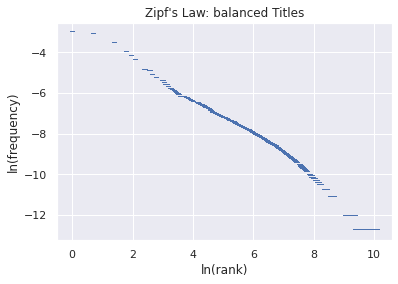

In [ ]:
zipf_balanced_title_data = np.array(balanced_title_normalized_vocab_df['count'])
zipf_balanced_title_data = np.log(zipf_balanced_title_data / zipf_balanced_title_data.sum())
zipf_balanced_title_plot = sns.scatterplot(y=zipf_balanced_title_data,
                            x=np.log(np.arange(1, len(zipf_balanced_title_data) + 1)), 
                            marker='$-$',
                            edgecolor='none')
zipf_balanced_title_plot.set_title("Zipf's Law: balanced Titles")
zipf_balanced_title_plot.set_xlabel('ln(rank)')
zipf_balanced_title_plot.set_ylabel('ln(frequency)')
zipf_balanced_title_plot.get_figure().savefig(FOLDERNAME + 'data/figures/zipf_balanced_title_plot.png')

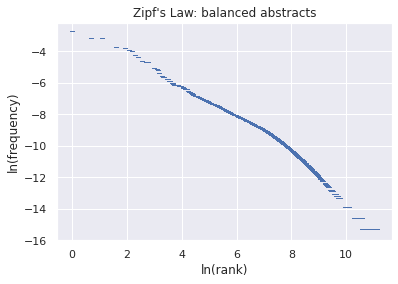

In [ ]:
zipf_balanced_abstract_data = np.array(balanced_abstract_normalized_vocab_df['count'])
zipf_balanced_abstract_data = np.log(zipf_balanced_abstract_data / zipf_balanced_abstract_data.sum())
zipf_balanced_abstract_plot = sns.scatterplot(y=zipf_balanced_abstract_data,
                            x=np.log(np.arange(1, len(zipf_balanced_abstract_data) + 1)), 
                            marker='$-$',
                            edgecolor='none')
zipf_balanced_abstract_plot.set_title("Zipf's Law: balanced abstracts")
zipf_balanced_abstract_plot.set_xlabel('ln(rank)')
zipf_balanced_abstract_plot.set_ylabel('ln(frequency)')
zipf_balanced_abstract_plot.get_figure().savefig(FOLDERNAME + 'data/figures/zipf_balanced_abstract_plot.png')

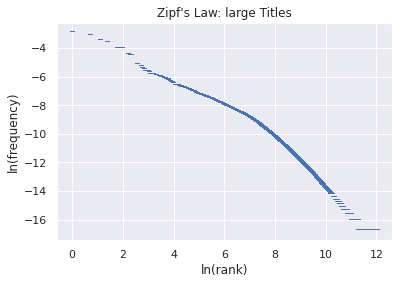

In [ ]:
zipf_large_title_data = np.array(large_title_normalized_vocab_df['count'])
zipf_large_title_data = np.log(zipf_large_title_data / zipf_large_title_data.sum())
zipf_large_title_plot = sns.scatterplot(y=zipf_large_title_data,
                            x=np.log(np.arange(1, len(zipf_large_title_data) + 1)), 
                            marker='$-$',
                            edgecolor='none')
zipf_large_title_plot.set_title("Zipf's Law: large Titles")
zipf_large_title_plot.set_xlabel('ln(rank)')
zipf_large_title_plot.set_ylabel('ln(frequency)')
zipf_large_title_plot.get_figure().savefig(FOLDERNAME + 'data/figures/zipf_large_title_plot.png')

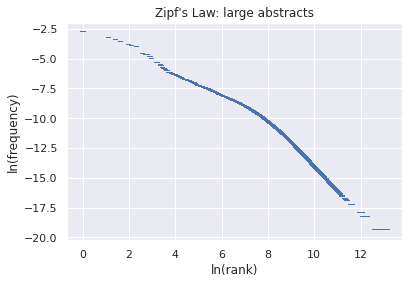

In [ ]:
zipf_large_abstract_data = np.array(large_abstract_normalized_vocab_df['count'])
zipf_large_abstract_data = np.log(zipf_large_abstract_data / zipf_large_abstract_data.sum())
zipf_large_abstract_plot = sns.scatterplot(y=zipf_large_abstract_data,
                            x=np.log(np.arange(1, len(zipf_large_abstract_data) + 1)), 
                            marker='$-$',
                            edgecolor='none')
zipf_large_abstract_plot.set_title("Zipf's Law: large abstracts")
zipf_large_abstract_plot.set_xlabel('ln(rank)')
zipf_large_abstract_plot.set_ylabel('ln(frequency)')
zipf_large_abstract_plot.get_figure().savefig(FOLDERNAME + 'data/figures/zipf_large_abstract_plot.png')